### Installing and Importing Dependencies

In [1]:
!pip install folium
!pip install ipympl
!pip install prettytable

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns
sns.set_style('whitegrid')
import folium
import geopandas as gpd
from shapely.geometry import Polygon, Point
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle
import gc
from prettytable import PrettyTable

def save(var):
    outfile = open(var + ".pickle", "wb")
    pickle.dump(eval(var), outfile)
    outfile.close()

def load(var):
    infile = open(var + ".pickle", "rb")
    globals()[var] = pickle.load(infile)
    infile.close()

In [2]:
# Set Pandas options to display all rows and all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

In [3]:
sampled_data = pd.read_csv('chicago_data_5.2_perc_sample.csv')
sampled_data.head()

,Unnamed: 0,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,percent_time_chicago,percent_distance_chicago,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tip,additional_charges,trip_total,shared_trip_authorized,shared_trip_match,trips_pooled,pickup_centroid_location,dropoff_centroid_location,temp,dwpt,rhum,prcp,wdir,wpgt,pres
0,453863,2023-05-14T09:00:00.000,2023-05-14T09:00:00.000,314.0,1.37,0.9937,0.9920,1.703183e+10,1.703106e+10,7.0,6.0,12.5,0.0,2.10,14.60,True,False,1,POINT (-87.6640782395 41.9218774613),POINT (-87.6467297286 41.9346591566),14.4,7.9,65.0,0.0,20.0,NaN,1024.0
1,681723,2023-05-06T22:15:00.000,2023-05-06T22:15:00.000,615.0,2.43,0.9985,1.0000,1.703132e+10,1.703183e+10,32.0,28.0,12.5,0.0,2.76,15.26,False,False,1,POINT (-87.6219716519 41.8774061234),POINT (-87.6540926517 41.8716894745),25.0,12.9,47.0,0.0,150.0,NaN,1012.5
2,548264,2023-05-09T10:15:00.000,2023-05-09T10:45:00.000,1475.0,13.36,0.9985,0.9956,1.703105e+10,1.703198e+10,5.0,76.0,20.0,0.0,23.75,43.75,False,False,1,POINT (-87.6835062305 41.9504425991),POINT (-87.9030396611 41.9790708201),8.9,7.2,89.0,0.0,340.0,NaN,1018.0
3,199697,2023-05-12T17:30:00.000,2023-05-12T18:00:00.000,1413.0,6.52,0.9995,0.9880,1.703106e+10,1.703108e+10,6.0,8.0,30.0,0.0,5.58,35.60,False,False,1,POINT (-87.6665362813 41.9506733576),POINT (-87.6318639497 41.8920421365),25.0,16.7,60.0,0.0,140.0,NaN,1016.0
4,165024,2023-05-08T20:30:00.000,2023-05-08T20:45:00.000,335.0,1.33,1.0000,1.0000,1.703184e+10,1.703141e+10,41.0,41.0,5.0,0.0,1.23,6.23,False,False,1,POINT (-87.6012851221 41.7904693995),POINT (-87.5853031602 41.8012268363),12.8,11.0,89.0,2.1,30.0,NaN,1014.0


### Data cleaning

In [4]:
sampled_data.rename(columns={'Unnamed: 0':'Trip_id'},inplace=True)

In [5]:
sampled_data.isna().sum()/len(sampled_data)

Trip_id                      0.000000
trip_start_timestamp         0.000000
trip_end_timestamp           0.000000
trip_seconds                 0.000026
trip_miles                   0.000000
percent_time_chicago         0.002198
percent_distance_chicago     0.002253
pickup_census_tract          0.383433
dropoff_census_tract         0.385437
pickup_community_area        0.088060
dropoff_community_area       0.091851
fare                         0.004521
tip                          0.004521
additional_charges           0.004521
trip_total                   0.004521
shared_trip_authorized       0.000000
shared_trip_match            0.000000
trips_pooled                 0.000000
pickup_centroid_location     0.085121
dropoff_centroid_location    0.089240
temp                         0.000000
dwpt                         0.000000
rhum                         0.000000
prcp                         0.000000
wdir                         0.000000
wpgt                         1.000000
pres        

In [6]:
gc.collect()

0

In [7]:
sampled_data = sampled_data.drop(['pickup_census_tract','dropoff_census_tract', 'pickup_community_area',
                                  'shared_trip_authorized','shared_trip_match','trips_pooled','wpgt','trip_end_timestamp',
                                  'additional_charges','dropoff_community_area'],axis=1)

In [8]:
sampled_data = sampled_data.dropna(subset = 'pickup_centroid_location')

In [9]:
sampled_data.isna().sum()/len(sampled_data)

Trip_id                      0.000000
trip_start_timestamp         0.000000
trip_seconds                 0.000027
trip_miles                   0.000000
percent_time_chicago         0.002127
percent_distance_chicago     0.002189
fare                         0.004456
tip                          0.004456
trip_total                   0.004456
pickup_centroid_location     0.000000
dropoff_centroid_location    0.096865
temp                         0.000000
dwpt                         0.000000
rhum                         0.000000
prcp                         0.000000
wdir                         0.000000
pres                         0.000000
dtype: float64

### 3. Feature Engineering

#### 3.1. Creating date, hour, weekday, month, and year fields

In [10]:
## Creating month, day of week, year, hour, and date columns 

sampled_data['month'] = pd.to_datetime(sampled_data['trip_start_timestamp']).dt.month
sampled_data['dayofweek'] = pd.to_datetime(sampled_data['trip_start_timestamp']).dt.dayofweek
sampled_data['year'] = pd.to_datetime(sampled_data['trip_start_timestamp']).dt.year
sampled_data['hour'] = pd.to_datetime(sampled_data['trip_start_timestamp']).dt.hour
sampled_data['date'] = pd.to_datetime(sampled_data['trip_start_timestamp']).dt.day

In [11]:
sampled_data.head()

,Trip_id,trip_start_timestamp,trip_seconds,trip_miles,percent_time_chicago,percent_distance_chicago,fare,tip,trip_total,pickup_centroid_location,dropoff_centroid_location,temp,dwpt,rhum,prcp,wdir,pres,month,dayofweek,year,hour,date
0,453863,2023-05-14T09:00:00.000,314.0,1.37,0.9937,0.9920,12.5,0.0,14.60,POINT (-87.6640782395 41.9218774613),POINT (-87.6467297286 41.9346591566),14.4,7.9,65.0,0.0,20.0,1024.0,5,6,2023,9,14
1,681723,2023-05-06T22:15:00.000,615.0,2.43,0.9985,1.0000,12.5,0.0,15.26,POINT (-87.6219716519 41.8774061234),POINT (-87.6540926517 41.8716894745),25.0,12.9,47.0,0.0,150.0,1012.5,5,5,2023,22,6
2,548264,2023-05-09T10:15:00.000,1475.0,13.36,0.9985,0.9956,20.0,0.0,43.75,POINT (-87.6835062305 41.9504425991),POINT (-87.9030396611 41.9790708201),8.9,7.2,89.0,0.0,340.0,1018.0,5,1,2023,10,9
3,199697,2023-05-12T17:30:00.000,1413.0,6.52,0.9995,0.9880,30.0,0.0,35.60,POINT (-87.6665362813 41.9506733576),POINT (-87.6318639497 41.8920421365),25.0,16.7,60.0,0.0,140.0,1016.0,5,4,2023,17,12
4,165024,2023-05-08T20:30:00.000,335.0,1.33,1.0000,1.0000,5.0,0.0,6.23,POINT (-87.6012851221 41.7904693995),POINT (-87.5853031602 41.8012268363),12.8,11.0,89.0,2.1,30.0,1014.0,5,0,2023,20,8


#### 3.2. Partitioning Chicago into 100 zones 

In [12]:
sampled_data['pickup_longitude'] = sampled_data['pickup_centroid_location'].str.extract(r'POINT \(([-\d.]+)')  # Extracts longitude
sampled_data['pickup_latitude'] = sampled_data['pickup_centroid_location'].str.extract(r'POINT \([-\d.]+ ([-\d.]+)\)')  # Extracts latitude

# Convert the extracted columns to float for numerical operations
sampled_data['pickup_longitude'] = sampled_data['pickup_longitude'].astype(float)
sampled_data['pickup_latitude'] = sampled_data['pickup_latitude'].astype(float)

sampled_data.head()

,Trip_id,trip_start_timestamp,trip_seconds,trip_miles,percent_time_chicago,percent_distance_chicago,fare,tip,trip_total,pickup_centroid_location,dropoff_centroid_location,temp,dwpt,rhum,prcp,wdir,pres,month,dayofweek,year,hour,date,pickup_longitude,pickup_latitude
0,453863,2023-05-14T09:00:00.000,314.0,1.37,0.9937,0.9920,12.5,0.0,14.60,POINT (-87.6640782395 41.9218774613),POINT (-87.6467297286 41.9346591566),14.4,7.9,65.0,0.0,20.0,1024.0,5,6,2023,9,14,-87.664078,41.921877
1,681723,2023-05-06T22:15:00.000,615.0,2.43,0.9985,1.0000,12.5,0.0,15.26,POINT (-87.6219716519 41.8774061234),POINT (-87.6540926517 41.8716894745),25.0,12.9,47.0,0.0,150.0,1012.5,5,5,2023,22,6,-87.621972,41.877406
2,548264,2023-05-09T10:15:00.000,1475.0,13.36,0.9985,0.9956,20.0,0.0,43.75,POINT (-87.6835062305 41.9504425991),POINT (-87.9030396611 41.9790708201),8.9,7.2,89.0,0.0,340.0,1018.0,5,1,2023,10,9,-87.683506,41.950443
3,199697,2023-05-12T17:30:00.000,1413.0,6.52,0.9995,0.9880,30.0,0.0,35.60,POINT (-87.6665362813 41.9506733576),POINT (-87.6318639497 41.8920421365),25.0,16.7,60.0,0.0,140.0,1016.0,5,4,2023,17,12,-87.666536,41.950673
4,165024,2023-05-08T20:30:00.000,335.0,1.33,1.0000,1.0000,5.0,0.0,6.23,POINT (-87.6012851221 41.7904693995),POINT (-87.5853031602 41.8012268363),12.8,11.0,89.0,2.1,30.0,1014.0,5,0,2023,20,8,-87.601285,41.790469


In [13]:
# Get the boundary of the data (min and max lat/lon)
min_lat, max_lat = sampled_data['pickup_latitude'].min(), sampled_data['pickup_latitude'].max()
min_lon, max_lon = sampled_data['pickup_longitude'].min(), sampled_data['pickup_longitude'].max()

# Create a boundary rectangle as a Polygon
boundary_polygon = Polygon([
    (min_lon, min_lat),
    (min_lon, max_lat),
    (max_lon, max_lat),
    (max_lon, min_lat),
    (min_lon, min_lat)
])

# Partition the boundary rectangle into a 10x10 grid
grid_size_x = (max_lon - min_lon) / 10  # Width of each grid cell
grid_size_y = (max_lat - min_lat) / 10  # Height of each grid cell

# Create grid cells as polygons
polygons = []
for i in range(10):
    for j in range(10):
        x_start = min_lon + i * grid_size_x
        y_start = min_lat + j * grid_size_y
        x_end = x_start + grid_size_x
        y_end = y_start + grid_size_y
        polygons.append(Polygon([(x_start, y_start), (x_start, y_end), (x_end, y_end), (x_end, y_start), (x_start, y_start)]))

# Step 3: Visualize on a Folium map
# Create a map centered around the center of the data
map_center = [(min_lat + max_lat) / 2, (min_lon + max_lon) / 2]
chicago_map = folium.Map(location=map_center, zoom_start=11)

# Add grid polygons to the map
for polygon in polygons:
    geojson = gpd.GeoSeries([polygon]).__geo_interface__
    folium.GeoJson(geojson, style_function=lambda x: {'fillColor': 'blue', 'color': 'black', 'weight': 1, 'fillOpacity': 0.1}).add_to(chicago_map)

# Display the map
chicago_map

In [14]:
def allocate_zone(lat, lon):
    # Calculate the row and column based on lat/lon position in the grid
    col = int((lon - min_lon) // grid_size_x)
    row = int((lat - min_lat) // grid_size_y)
    # Ensure col and row do not exceed 9 (the maximum index for a 10x10 grid)
    col = min(max(col, 0), 9)
    row = min(max(row, 0), 9)
    # Zone number calculation (row-major order)
    zone_number = row * 10 + col + 1  # +1 to start numbering from 1
    return zone_number

# Apply the function to create the 'zone' column
sampled_data['zone'] = sampled_data.apply(lambda row: allocate_zone(row['pickup_latitude'], row['pickup_longitude']), axis=1)


In [15]:
sampled_data.head()

,Trip_id,trip_start_timestamp,trip_seconds,trip_miles,percent_time_chicago,percent_distance_chicago,fare,tip,trip_total,pickup_centroid_location,dropoff_centroid_location,temp,dwpt,rhum,prcp,wdir,pres,month,dayofweek,year,hour,date,pickup_longitude,pickup_latitude,zone
0,453863,2023-05-14T09:00:00.000,314.0,1.37,0.9937,0.9920,12.5,0.0,14.60,POINT (-87.6640782395 41.9218774613),POINT (-87.6467297286 41.9346591566),14.4,7.9,65.0,0.0,20.0,1024.0,5,6,2023,9,14,-87.664078,41.921877,77
1,681723,2023-05-06T22:15:00.000,615.0,2.43,0.9985,1.0000,12.5,0.0,15.26,POINT (-87.6219716519 41.8774061234),POINT (-87.6540926517 41.8716894745),25.0,12.9,47.0,0.0,150.0,1012.5,5,5,2023,22,6,-87.621972,41.877406,68
2,548264,2023-05-09T10:15:00.000,1475.0,13.36,0.9985,0.9956,20.0,0.0,43.75,POINT (-87.6835062305 41.9504425991),POINT (-87.9030396611 41.9790708201),8.9,7.2,89.0,0.0,340.0,1018.0,5,1,2023,10,9,-87.683506,41.950443,86
3,199697,2023-05-12T17:30:00.000,1413.0,6.52,0.9995,0.9880,30.0,0.0,35.60,POINT (-87.6665362813 41.9506733576),POINT (-87.6318639497 41.8920421365),25.0,16.7,60.0,0.0,140.0,1016.0,5,4,2023,17,12,-87.666536,41.950673,87
4,165024,2023-05-08T20:30:00.000,335.0,1.33,1.0000,1.0000,5.0,0.0,6.23,POINT (-87.6012851221 41.7904693995),POINT (-87.5853031602 41.8012268363),12.8,11.0,89.0,2.1,30.0,1014.0,5,0,2023,20,8,-87.601285,41.790469,39


In [16]:
len(set(sampled_data['zone']))

57

In [17]:
max(sampled_data['zone']), min(sampled_data['zone'])

(97, 6)

#### 3.3. Price per mile and Average flow speed

In [18]:
filtered_df = sampled_data.drop(['trip_start_timestamp','percent_time_chicago','percent_distance_chicago',
                                 'pickup_centroid_location','dropoff_centroid_location','Trip_id'],axis=1)

In [19]:
filtered_df['farePerMile'] = filtered_df['fare']/filtered_df['trip_miles']
filtered_df['pricePerMile'] = (filtered_df['trip_total']-filtered_df['tip'])/filtered_df['trip_miles']
filtered_df['avgFlowSpeed_mph'] = filtered_df['trip_miles']*3600/filtered_df['trip_seconds']
filtered_df.head()

,trip_seconds,trip_miles,fare,tip,trip_total,temp,dwpt,rhum,prcp,wdir,pres,month,dayofweek,year,hour,date,pickup_longitude,pickup_latitude,zone,farePerMile,pricePerMile,avgFlowSpeed_mph
0,314.0,1.37,12.5,0.0,14.60,14.4,7.9,65.0,0.0,20.0,1024.0,5,6,2023,9,14,-87.664078,41.921877,77,9.124088,10.656934,15.707006
1,615.0,2.43,12.5,0.0,15.26,25.0,12.9,47.0,0.0,150.0,1012.5,5,5,2023,22,6,-87.621972,41.877406,68,5.144033,6.279835,14.224390
2,1475.0,13.36,20.0,0.0,43.75,8.9,7.2,89.0,0.0,340.0,1018.0,5,1,2023,10,9,-87.683506,41.950443,86,1.497006,3.274701,32.607458
3,1413.0,6.52,30.0,0.0,35.60,25.0,16.7,60.0,0.0,140.0,1016.0,5,4,2023,17,12,-87.666536,41.950673,87,4.601227,5.460123,16.611465
4,335.0,1.33,5.0,0.0,6.23,12.8,11.0,89.0,2.1,30.0,1014.0,5,0,2023,20,8,-87.601285,41.790469,39,3.759398,4.684211,14.292537


In [20]:
filtered_df = filtered_df.drop(['trip_seconds','trip_miles','fare','tip','trip_total',
                                'pickup_longitude','pickup_latitude'],axis=1)
filtered_df['trip_count'] = 1
filtered_df.head()

,temp,dwpt,rhum,prcp,wdir,pres,month,dayofweek,year,hour,date,zone,farePerMile,pricePerMile,avgFlowSpeed_mph,trip_count
0,14.4,7.9,65.0,0.0,20.0,1024.0,5,6,2023,9,14,77,9.124088,10.656934,15.707006,1
1,25.0,12.9,47.0,0.0,150.0,1012.5,5,5,2023,22,6,68,5.144033,6.279835,14.224390,1
2,8.9,7.2,89.0,0.0,340.0,1018.0,5,1,2023,10,9,86,1.497006,3.274701,32.607458,1
3,25.0,16.7,60.0,0.0,140.0,1016.0,5,4,2023,17,12,87,4.601227,5.460123,16.611465,1
4,12.8,11.0,89.0,2.1,30.0,1014.0,5,0,2023,20,8,39,3.759398,4.684211,14.292537,1


#### 3.4. Weather categorization (rainy/windy/sunny/hot/moderate/snowing etc. using k means clustering)

In [21]:
agg_funcs = {
    'temp': 'mean',  # Perform mean on weather parameters
    'dwpt': 'mean',
    'rhum': 'mean',
    'prcp': 'mean',
    'wdir': 'mean',
    'pres': 'mean',
    'dayofweek' : 'mean', # This would remain the same for a given date of the year, hence mean aggregation wouldn't change the actual value
    'farePerMile': 'mean',
    'pricePerMile': 'mean',
    'avgFlowSpeed_mph': 'mean',
    'trip_count': 'sum'    # Sum up the cab demand   
    
}

In [22]:
df_aggregated = filtered_df.groupby(['zone','month','date', 'year', 'hour']).agg(agg_funcs).reset_index()
df_aggregated.head()

,zone,month,date,year,hour,temp,dwpt,rhum,prcp,wdir,pres,dayofweek,farePerMile,pricePerMile,avgFlowSpeed_mph,trip_count
0,6,1,1,2024,0,1.0,-2.2,79.0,0.0,320.0,1018.0,0.0,1.532399,1.815674,41.716895,1
1,6,1,1,2024,2,1.1,-2.1,79.0,0.0,330.0,1019.0,0.0,2.119197,2.477830,27.925948,1
2,6,1,5,2024,15,0.0,-5.6,66.0,0.0,190.0,1026.0,4.0,0.750000,1.097500,36.511156,1
3,6,1,7,2024,3,1.1,-0.7,88.0,0.2,260.0,1006.5,6.0,5.785028,8.469281,22.711533,1
4,6,1,9,2024,9,1.1,-0.1,92.0,1.0,100.0,1003.0,1.0,1.543210,1.992593,35.823096,1


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [24]:
%%time

weather_columns = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'pres']
weather_data = df_aggregated[weather_columns]

scaler = StandardScaler()
normalized_weather_data = scaler.fit_transform(weather_data)

kmeans = KMeans(n_clusters=6, random_state=42)  # Adjust n_clusters as needed
df_aggregated['weather_category'] = kmeans.fit_predict(normalized_weather_data)

df_aggregated.head()

c:\Users\mahen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: total: 16.4 s
Wall time: 4.71 s


,zone,month,date,year,hour,temp,dwpt,rhum,prcp,wdir,pres,dayofweek,farePerMile,pricePerMile,avgFlowSpeed_mph,trip_count,weather_category
0,6,1,1,2024,0,1.0,-2.2,79.0,0.0,320.0,1018.0,0.0,1.532399,1.815674,41.716895,1,0
1,6,1,1,2024,2,1.1,-2.1,79.0,0.0,330.0,1019.0,0.0,2.119197,2.477830,27.925948,1,2
2,6,1,5,2024,15,0.0,-5.6,66.0,0.0,190.0,1026.0,4.0,0.750000,1.097500,36.511156,1,2
3,6,1,7,2024,3,1.1,-0.7,88.0,0.2,260.0,1006.5,6.0,5.785028,8.469281,22.711533,1,0
4,6,1,9,2024,9,1.1,-0.1,92.0,1.0,100.0,1003.0,1.0,1.543210,1.992593,35.823096,1,0


In [25]:
gc.collect()

194

In [51]:
df = df_aggregated.drop(['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'pres'],axis=1)

#### 3.5. Number of trips in past 1,2, and 3 months (we'll do it for hour instead of month, other metrics like std on hour etc.) Also, average flow speed for past 1, 2 and 3 hours this might predict any traffic situations due to accidents and other

In [52]:
df.head()

,zone,month,date,year,hour,dayofweek,farePerMile,pricePerMile,avgFlowSpeed_mph,trip_count,weather_category
0,6,1,1,2024,0,0.0,1.532399,1.815674,41.716895,1,0
1,6,1,1,2024,2,0.0,2.119197,2.477830,27.925948,1,2
2,6,1,5,2024,15,4.0,0.750000,1.097500,36.511156,1,2
3,6,1,7,2024,3,6.0,5.785028,8.469281,22.711533,1,0
4,6,1,9,2024,9,1.0,1.543210,1.992593,35.823096,1,0


In [53]:
df = df.sort_values(by = ['zone','year','month','date','hour']).reset_index(drop = True)

In [54]:
df['n_minus_1_hour_trips'] = df.groupby(['zone','year','month','date'])['trip_count'].shift(1)
df['n_minus_2_hour_trips'] = df.groupby(['zone','year','month','date'])['trip_count'].shift(2)
df['n_minus_3_hour_trips'] = df.groupby(['zone','year','month','date'])['trip_count'].shift(3)

In [117]:
df.tail()

,zone,month,date,year,hour,dayofweek,farePerMile,pricePerMile,avgFlowSpeed_mph,trip_count,weather_category,n_minus_1_hour_trips,n_minus_2_hour_trips,n_minus_3_hour_trips
372302,97,4,30,2024,19,1.0,3.032431,3.802328,18.966260,13,5,8.0,18.0,24.0
372303,97,4,30,2024,20,1.0,2.810047,3.425412,16.508001,9,5,13.0,8.0,18.0
372304,97,4,30,2024,21,1.0,3.848921,5.877788,14.027107,6,5,9.0,13.0,8.0
372305,97,4,30,2024,22,1.0,3.341976,4.039699,17.835467,11,5,6.0,9.0,13.0
372306,97,4,30,2024,23,1.0,3.994651,5.401911,20.834279,8,5,11.0,6.0,9.0


In [50]:
np.isinf(df).sum()

zone                      0
month                     0
date                      0
year                      0
hour                      0
dayofweek                 0
farePerMile             363
pricePerMile            364
avgFlowSpeed_mph          1
trip_count                0
weather_category          0
n_minus_1_hour_trips      0
n_minus_2_hour_trips      0
n_minus_3_hour_trips      0
dtype: int64

In [56]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['n_minus_1_hour_trips'] = df['n_minus_1_hour_trips'].fillna(0)
df['n_minus_2_hour_trips'] = df['n_minus_2_hour_trips'].fillna(0)
df['n_minus_3_hour_trips'] = df['n_minus_3_hour_trips'].fillna(0)
df = df.dropna(subset=['farePerMile','pricePerMile','avgFlowSpeed_mph'])

### EDA

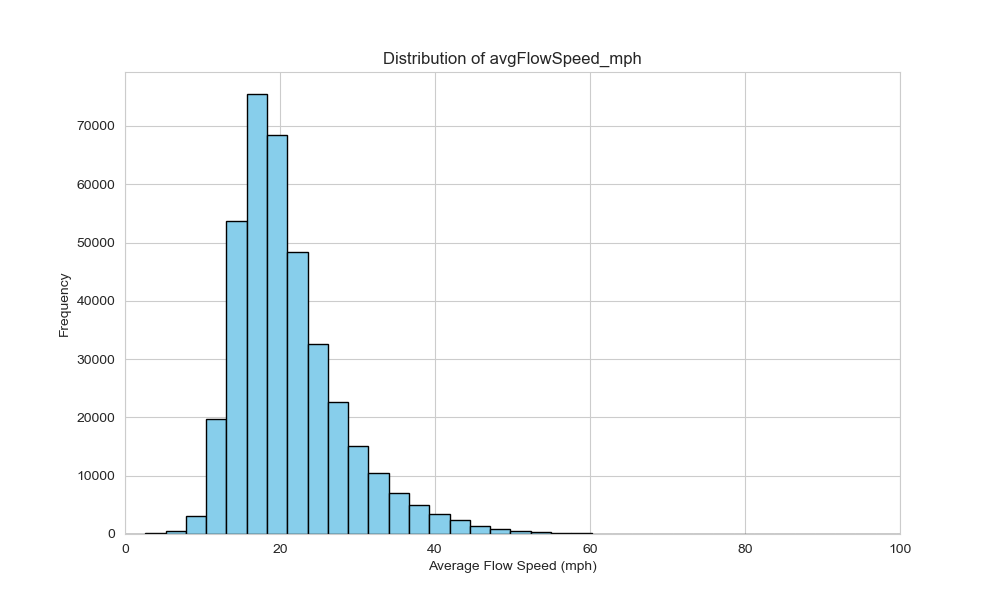

In [67]:
# Distribution of average speed

plt.figure(figsize=(10, 6))
plt.hist(df['avgFlowSpeed_mph'], bins=500, color='skyblue', edgecolor='black')
plt.xlabel('Average Flow Speed (mph)')
plt.ylabel('Frequency')
plt.title('Distribution of avgFlowSpeed_mph')
plt.xlim(0, 100) 
plt.show()

### Baseline Models

In [57]:
#Linear regression model

In [58]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score, classification_report, confusion_matrix, roc_curve 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

In [59]:
X = df[['zone', 'year', 'month', 'date', 'hour', 'farePerMile', 'pricePerMile', 'avgFlowSpeed_mph', 
        'n_minus_1_hour_trips', 'n_minus_2_hour_trips', 'n_minus_3_hour_trips']]
y = df['trip_count']

In [60]:
model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

LinearRegression()

In [68]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
lr_mse = mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)

print(f'MSE is : {lr_mse} | r2_score is {lr_r2}')

MSE is : 62.97597110242287 | r2_score is 0.8782529905552501


In [69]:
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.base import BaseEstimator, RegressorMixin

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data into LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


In [71]:
%%time

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "max_depth": 6,  
    "learning_rate": 0.019,
    "n_estimators": 3000,  
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.8,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64,
    
    "verbose": 500,
}


cv = StratifiedKFold(n_splits=4, shuffle=False)
n_est = 3000

fitted_models_cat = []
fitted_models_lgb = []

cv_scores_cat = []
cv_scores_lgb = []


for idx_train, idx_valid in cv.split(X_train, y_train):#
    
    X_sub_train, y_sub_train = X_train.iloc[idx_train], y_train.iloc[idx_train]# 
    X_valid, y_valid = X_train.iloc[idx_valid], y_train.iloc[idx_valid]
    
    train_pool = Pool(X_sub_train, y_sub_train)
    val_pool = Pool(X_valid, y_valid)
    
    clf = CatBoostRegressor(
    eval_metric='R2',
    depth = 6,
    learning_rate = 0.022,
    early_stopping_rounds = 500,
    iterations=n_est)
    
    clf.fit(train_pool, eval_set=val_pool,verbose=500)
    
    fitted_models_cat.append(clf)
    y_pred_valid = clf.predict(X_valid)
    auc_score = r2_score(y_valid, y_pred_valid)
    cv_scores_cat.append(auc_score)
    
    
    model = LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)]
        )
    
    fitted_models_lgb.append(model)
    y_pred_valid = model.predict(X_valid)
    auc_score = r2_score(y_valid, y_pred_valid)
    cv_scores_lgb.append(auc_score)
    
    
print("CV AUC scores: ", cv_scores_cat)
print("Maximum CV AUC score: ", max(cv_scores_cat))


print("CV AUC scores: ", cv_scores_lgb)
print("Maximum CV AUC score: ", max(cv_scores_lgb))

c:\Users\mahen\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


0:	learn: 0.0364568	test: 0.0367074	best: 0.0367074 (0)	total: 138ms	remaining: 6m 53s
500:	learn: 0.9445172	test: 0.9417406	best: 0.9417406 (500)	total: 5.26s	remaining: 26.3s
1000:	learn: 0.9521075	test: 0.9481151	best: 0.9481151 (1000)	total: 10s	remaining: 20s
1500:	learn: 0.9559710	test: 0.9509117	best: 0.9509117 (1500)	total: 14.7s	remaining: 14.6s
2000:	learn: 0.9584229	test: 0.9523711	best: 0.9523711 (2000)	total: 19.2s	remaining: 9.58s
2500:	learn: 0.9601696	test: 0.9533019	best: 0.9533019 (2500)	total: 23.7s	remaining: 4.72s
2999:	learn: 0.9616091	test: 0.9539885	best: 0.9539887 (2998)	total: 28.5s	remaining: 0us

bestTest = 0.9539887166
bestIteration = 2998

Shrink model to first 2999 iterations.
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.032957
[LightGBM] [Debug] init for col-wise cost 0.000012 seconds, init for row-wise cost 0.003359 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001654 seconds.
Yo

In [72]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y):
        # Fit each estimator on the training data
        for estimator in self.estimators:
            estimator.fit(X, y)
        return self
    
    def predict(self, X):
        # Make predictions with each estimator and compute the average prediction
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
   

model = VotingModel(fitted_models_cat + fitted_models_lgb)

In [73]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
boost_mse = mean_squared_error(y_test, y_pred)
boost_r2 = r2_score(y_test, y_pred)

print(f'MSE is : {boost_mse} | r2_score is {boost_r2}')

MSE is : 25.35102378361842 | r2_score is 0.9509906512279328


### LSTM Model (focus on relevant deep learning models)

In [105]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.compose import ColumnTransformer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [113]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    # Dropout(0.5),  # Dropout layer to randomly set 50% of the inputs to zero
    Dense(32, activation='relu'),
    # Dropout(0.5),  # Another dropout layer
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping callback to stop training if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model with early stopping and validation set
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=int(X_train.shape[0]/10),
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50


c:\Users\mahen\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3363.1531 - mae: 47.4758 - val_loss: 997.9515 - val_mae: 28.9729
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1206.3546 - mae: 29.5012 - val_loss: 608.0037 - val_mae: 17.8170
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 461.8151 - mae: 14.5167 - val_loss: 259.1079 - val_mae: 8.5553
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 322.8503 - mae: 10.4749 - val_loss: 270.1821 - val_mae: 12.3608
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 251.3978 - mae: 9.8805 - val_loss: 176.7547 - val_mae: 8.1010
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 181.8413 - mae: 8.1545 - val_loss: 146.5298 - val_mae: 6.5581
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 161.5770 - mae: 6.8222 - val_loss: 134.3674 - val_mae: 6.2382
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 138.6191 - mae: 6.3895 - val_loss: 129.3719 - val_mae: 6.0364
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step -

In [114]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
nn_mse = mean_squared_error(y_test, y_pred.flatten())
nn_r2 = r2_score(y_test, y_pred.flatten())

print(f'MSE is : {nn_mse} | r2_score is {nn_r2}')

2322/2322 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step
MSE is : 63.69001459208118 | r2_score is 0.8768725805677963


### Model Evaluation

In [115]:
model_names = ['Linear Regression', 'Gradient Boosting', 'Neural Network']
mse_values = [lr_mse, boost_mse, nn_mse]
r2_values = [lr_r2, boost_r2, nn_r2]

In [116]:
data = {
    'Model': model_names,
    'Mean Squared Error (MSE)': mse_values,
    'R-squared (R²)': r2_values
}

# Create a DataFrame from the data dictionary
df_results = pd.DataFrame(data)

# Display the DataFrame with custom style
df_results.style.set_caption("Model Performance Comparison").format({
    'Mean Squared Error (MSE)': '{:.4f}', 
    'R-squared (R²)': '{:.4f}'
}).set_properties(**{'background-color': '#f0f0f0', 'color': 'black', 'border-color': 'black', 'text-align': 'center'})

,Model,Mean Squared Error (MSE),R-squared (R²)
0,Linear Regression,62.9760,0.8783
1,Gradient Boosting,25.3510,0.9510
2,Neural Network,63.6900,0.8769
